IMPORTATION DES LIBRARY

In [10]:
import numpy as np
from scipy.stats import multivariate_normal
from numpy.linalg import inv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit

GENETRATION DU JEUX DE DONNNEES INITIAL

In [2]:
n = 10 # Nombre de ligne 
d = 2  # Nombre de colonne
b = 2
X=np.random.uniform(-4, 4, size=(n, d)) # Matrce des variable
target_normal = multivariate_normal(mean=np.random.normal(size=d), cov=np.eye(d))
y =target_normal.pdf(X) # variable à prédire


TROUVONS LA MATICE A CONSTRUIRE AVEC LE KERNEL GAUSSIEN 

In [15]:
def compute_sigmasq(X): 
    xcross = np.dot(X, X.T)
    xnorms = np.repeat(np.diag(np.dot(X, X.T)).reshape(1, -1), np.size(X, axis=0), axis=0)
    return(np.median(xnorms - 2*xcross + xnorms.T))
sigmasq = compute_sigmasq(X)

def rbf(centroid):    
    def rbfdot(x):
        return(np.exp(-np.sum((x - centroid)**2) / sigmasq))
    return(rbfdot)

n_centroids=2 
def get_centroids(X, n_centroids):
    idx = np.random.randint(np.size(X, axis=0), size=n_centroids)
    return(X[idx, :])
    
centroids=get_centroids(X, n_centroids)    

def compute_phiX(X, centroids):
    rbfs = [rbf(centroid) for centroid in centroids]
    list_columns = list(map(lambda f: np.apply_along_axis(f, 1, X), rbfs))
    list_columns.insert(0, np.repeat(1, np.size(X, axis=0)))
    phiX = np.column_stack(list_columns)
    return(phiX)
phi=compute_phiX(X, centroids)
phi

array([[1.        , 0.06595559, 0.13442788],
       [1.        , 0.07689586, 0.36497385],
       [1.        , 0.69254664, 1.        ],
       [1.        , 1.        , 0.69254664],
       [1.        , 0.88297791, 0.67987342],
       [1.        , 0.97969746, 0.60832233],
       [1.        , 0.73092043, 0.46263853],
       [1.        , 0.32405652, 0.80078948],
       [1.        , 0.19999934, 0.40313312],
       [1.        , 0.12441624, 0.4741835 ]])

EVALUATION DU MODEL EN FONTION DES DIFFERENTES VALEURS DU PARAMETRE DE REGULARISATION 

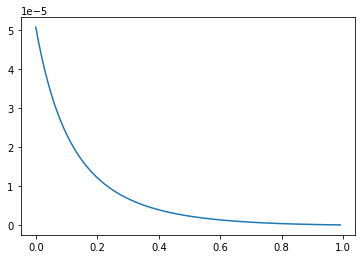

In [8]:
phiX_train, phiX_test, y_train, y_test = train_test_split(phi,y, test_size=0.02, random_state=42) 
reg_coefs=[i/100 for i in range(100) ]
def reg_coef_evaluation_RBF(reg_coefs,phiX_train,y_train,phiX_test,y_test):
    liste=[]
    for coef in reg_coefs:
        w = np.dot(inv(np.dot(phiX_train.T, phiX_train) + coef*np.eye(n_centroids+1)),np.dot(phiX_train.T,y_train))
        y_test_pred=np.dot(phiX_test, w)
        MSE=sum((y_test_pred-y_test)**2)/len(y_test_pred)
        liste.append(MSE)
    return liste
Eval_1=reg_coef_evaluation_RBF(reg_coefs,phiX_train,y_train,phiX_test,y_test)
plt.plot(reg_coefs,Eval_1)

UTILISATION DE LA ALIDATION CROISER POUR EVALUER PLUS ROBUSTEMENT LES VALEURS DU PARAMETRE DE REGULARISATION

[0.0, 0.0014759622694467483]

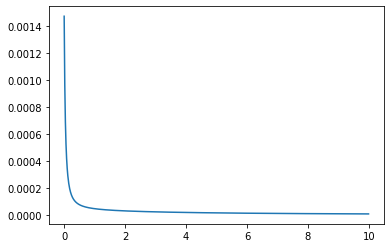

In [11]:
def reg_coef_evaluation_RBF_cv(reg_coefs,phiX_train,y_train,phiX_test,y_test):
        w = np.dot(inv(np.dot(phiX_train.T, phiX_train) + reg_coefs*np.eye(n_centroids+1)),np.dot(phiX_train.T,y_train))
        y_test_pred=np.dot(phiX_test, w)
        MSE=sum((y_test_pred-y_test)**2)/len(y_test_pred)
        return MSE

def CV_select_best_lambda(phiX_train,y_train,reg_coefs,k_fold):
    D=np.c_[phiX_train,y_train]  
    ss = ShuffleSplit(n_splits=k_fold, test_size=0.20, random_state=0)
    L=[]
    for lambdaa in reg_coefs:  
        s=0
        for train_index, test_index in ss.split(D):
            D_train,D_test = D[train_index,],D[test_index,]
            X_train, Y_Train = D_train[:,:-1], D_train[:,-1]
            X_test, Y_test = D_test[:,:-1], D_test[:,-1]    
            s=s+reg_coef_evaluation_RBF_cv(lambdaa,X_train,Y_Train,X_test, Y_test)    
        L.append(s/k_fold)    
    return L 

k_fold=5
reg_coefs=[i/100 for i in range(1000) ]
Eval_1=CV_select_best_lambda(phiX_train,y_train,reg_coefs,k_fold)
plt.plot(reg_coefs,Eval_1)

lE RESULTAT CI-DESOUS NOUS MOTRE QUE SI LE PARAMETRE EST EGALE A 0 ON TOMBE DE LE CAS DE LA REGRESSION LINEAIRE SIMPLE QUI NOUS FOURNI LA PLUS GRANDE EURREU ? COMME ON LE VOIT SUR LA FIGURE CI-DESSU L'Eurre DEVIENT PLUS PETTITE LORSQUE LE PARRAMETTRE AUGMENTE.    

In [13]:
index =Eval_1.index(min(Eval_1))
index_2 =Eval_1.index(max(Eval_1))
print([reg_coefs[index_2],max(Eval_1)]) # la valeur du parametre pour laquelle l'eurr est plus grande  
print([reg_coefs[index],min(Eval_1)]) # la valeur du parametre pour laquelle l'eurr est plus petite  

[0.0, 0.0014759622694467483]
[9.99, 8.176029393463257e-06]


TRAVAILLONS MAINTEMANT SUR LE CAS POLYNOMIALE

In [27]:
# Ici nous construisons une fonction polynome de la forme: têta0 + têta1*xi + têta2*xi^2 + .......+ têta2*xi^p
# dans notre cas xi est la première colone du jeux de données iitiale et p vaut 3(le dégré du polynome)   
def Polynomiale(X,col,degre_vj):
    V=np.zeros((X.shape[0],degre_vj))
    for i in range(0,degre_vj):
        p=X[:,col]
        V[:,i]=np.power(p,i+1)
    return V    
X_poly=Polynomiale(X,0,4) 
X_poly      

array([[ 3.54098942e+00,  1.25386061e+01,  4.43990713e+01,
         1.57216642e+02],
       [ 2.18820631e+00,  4.78824687e+00,  1.04776720e+01,
         2.29273081e+01],
       [-1.22771682e+00,  1.50728860e+00, -1.85052358e+00,
         2.27191893e+00],
       [-2.96673529e+00,  8.80151828e+00, -2.61117749e+01,
         7.74667241e+01],
       [-3.68941624e+00,  1.36117922e+01, -5.02195672e+01,
         1.85280887e+02],
       [-2.90786694e+00,  8.45569013e+00, -2.45880218e+01,
         7.14986956e+01],
       [-1.59902973e+00,  2.55689609e+00, -4.08855287e+00,
         6.53771760e+00],
       [-4.12715143e-01,  1.70333789e-01, -7.02993340e-02,
         2.90135997e-02],
       [ 2.16115217e+00,  4.67057870e+00,  1.00938313e+01,
         2.18143054e+01],
       [ 1.99294575e+00,  3.97183277e+00,  7.91564723e+00,
         1.57754555e+01]])

EVALUATION DU MODEL EN FONTION DES DIFFERENTES VALEURS DU PARAMETRE DE REGULARISATION

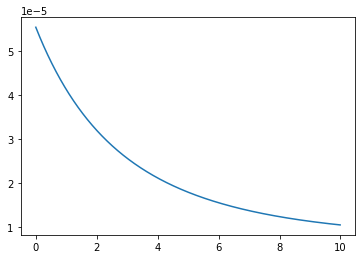

In [28]:
X_poly_train, X_poly_test, y_train, y_test = train_test_split( X_poly,y, test_size=0.02, random_state=42) 
reg_coefs=[i/100 for i in range(1000) ]
def reg_coef_evaluation_poly(reg_coefs,phiX_train,y_train,phiX_test,y_test):
    liste=[]
    for coef in reg_coefs:
        w = np.dot(inv(np.dot(phiX_train.T, phiX_train) + coef*np.eye(phiX_train.shape[1])),np.dot(phiX_train.T,y_train))
        y_test_pred=np.dot(phiX_test, w)
        MSE=sum((y_test_pred-y_test)**2)/len(y_test_pred)
        liste.append(MSE)
    return liste
Eval_2=reg_coef_evaluation_poly(reg_coefs,X_poly_train,y_train,X_poly_test,y_test)
plt.plot(reg_coefs,Eval_2)

UTILISATION DE LA ALIDATION CROISER POUR EVALUER PLUS ROBUSTEMENT LES VALEURS DU PARAMETRE DE REGULARISATION

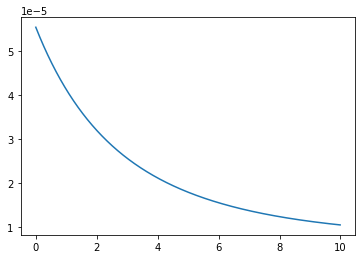

In [29]:
def reg_coef_evaluation_poly_cv(reg_coefs,phiX_train,y_train,phiX_test,y_test):
        w = np.dot(inv(np.dot(phiX_train.T, phiX_train) + reg_coefs*np.eye(phiX_train.shape[1])),np.dot(phiX_train.T,y_train))
        y_test_pred=np.dot(phiX_test, w)
        MSE=sum((y_test_pred-y_test)**2)/len(y_test_pred)
        return MSE
def CV_select_best_lambda(X_poly_train,y_train,reg_coefs,k_fold):
    D=np.c_[X_poly_train,y_train]  
    ss = ShuffleSplit(n_splits=k_fold, test_size=0.20, random_state=0)
    L=[]
    for lambdaa in reg_coefs:  
        s=0
        for train_index, test_index in ss.split(D):
            D_train,D_test = D[train_index,],D[test_index,]
            X_train, Y_Train = D_train[:,:-1], D_train[:,-1]
            X_test, Y_test = D_test[:,:-1], D_test[:,-1]    
            s=s+reg_coef_evaluation_poly_cv(lambdaa,X_train,Y_Train,X_test,Y_test)    
        L.append(s/k_fold)    
    return L 
k_fold=5
reg_coefs=[i/100 for i in range(1000) ]
Eval_3=CV_select_best_lambda(X_poly_train,y_train,reg_coefs,k_fold)
plt.plot(reg_coefs,Eval_2)

lE RESULTAT CI-DESOUS NOUS MOTRE QUE SI LE PARAMETRE EST EGALE A 0 ON TOMBE DE LE CAS DE LA REGRESSION LINEAIRE SIMPLE QUI NOUS FOURNI LA PLUS GRANDE EURREU ? COMME ON LE VOIT SUR LA FIGURE CI-DESSU L'Eurre DEVIENT PLUS PETTITE LORSQUE LE PARRAMETTRE AUGMENTE.

In [30]:
index =Eval_3.index(min(Eval_3))
index_2 =Eval_3.index(max(Eval_3))
print([reg_coefs[index_2],max(Eval_3)]) # la valeur du parametre pour laquelle l'eurr est plus grande  
print([reg_coefs[index],min(Eval_3)]) # la valeur du parametre pour laquelle l'eurr est plus petite

[0.0, 0.019375687445566385]
[9.99, 0.0011381899184205449]
